In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

%matplotlib inline

# Simulation

In [71]:
# Params
n = 1000
f_true = lambda X: 2*X[:,0] + X[:,1] #np.square((X[:,0] + X[:,1]))*2/12.901058

# Generate Data
X = np.matrix(np.random.randn(2*n, 2))

# Remove outliers
ind_not_outlier = np.array(np.multiply((abs(X) < 3)[:,0], (abs(X) < 3)[:,1]).T)[0]
X = X[ind_not_outlier, :][0:n, :]

# square elements of X
X = np.power(X, 2)
Y = f_true(X) + np.random.randn(n, 1)/1000

In [372]:
def trim(X, percent):
    
    alpha = (1 - percent)/2
    n, k = np.shape(X)
    t_ind = np.zeros((n, k))
    
    for i in range(0, k):
        upper_bd = np.percentile(X[:,i], (1 - alpha)*100)
        lower_bd = np.percentile(X[:,i], (alpha)*100)
        t_ind[:, i] = [int(lower_bd < x < upper_bd) for x in X[:,i]]
        
    return np.prod(t_ind, axis = 1)

def pdfn(x):
    return np.exp(-np.multiply(x, x)/2)/np.sqrt(2*np.pi)

# Conditional Expecttation
def CE_1(Y, X, arg, r):
    
    n_arg = np.shape(arg)[0]
    n = np.shape(X)[0]
    h = (n**(-r)) * np.std(X, axis = 0, ddof = 1)
    e = np.zeros((n_arg, 1))
    
    for j in range(0, n_arg):
        k = np.divide(pdfn(np.divide((arg[j] - X), h)), h)
        k = np.prod(k, axis = 1)   
        e[j] = (Y.T*k/n)/np.mean(k)
        
    return e

def SLS_1(b, Y, X, X_ind):
    
    v = X * np.matrix(b).T
    EY = CE_1(Y, v, v, 1/5)
    residual = np.power((Y - EY), 2)
    
    return (-0.5 * np.matrix(X_ind)*residual)


def semiparametricRegression(Y, X):
    
    guess = np.random.random((1, np.shape(X)[1]))
    obj_f = lambda x_0: -SLS_1(x_0, Y, X, trim(X, 0.98))
    result = minimize(obj_f, guess, method='BFGS')
    return result

def convert_hessian_to_cov(Y, X, results):
    
    sigma_2_hat = np.mean(np.power(Y - X*np.matrix(results.x).T, 2))
    return results.hess_inv * sigma_2_hat

def compute_marginal_effect(Y, X, ind, point, beta, delta = 0.01):

    point_nudge = np.copy(point)
    point_nudge[0, ind] = point_nudge[0, ind] + delta
    point_nudge = np.matrix(point_nudge)

    v_hat = X*beta
    v_hat_avg = point*beta
    v_hat_avg_nudge = point_nudge*beta
    
    return np.asscalar(CE_1(Y, v_hat, v_hat_avg_nudge, 1/5) - CE_1(Y, v_hat, v_hat_avg, 1/5))/delta

def calculate_me_range(Y, X, result, ind, point, delta = .001, delta_range = [0.0001, 0.01], n_1 = 200, n_2 = 5):

    beta = np.matrix(result.x).T
    
    me_results = np.zeros(shape = (n_1, 2, n_2))
    
    linspace_1 = np.linspace(0, 0.014, num = n_1)
    linspace_2 = np.linspace(delta_range[0], delta_range[1], num = n_2)
    
    for j in range(0, n_2):

        delta = linspace_2[j]
        #primp_avgt = np.linspace(0.001, 0.5, num = n_2)[j]

        for i in range(0, n_1):
  
            point_temp = np.copy(point)
            point_temp[0, ind] = linspace_1[i]
            
            me_vec = compute_marginal_effect(Y, X, ind, point_temp, beta, delta = delta)

            me_results[i,:,j] = np.array([linspace_1[i], np.asscalar(me_vec)])
            
    return me_results   

def find_tstats(Y, X, results):
    
    V = convert_hessian_to_cov(Y, X, results)

    n = np.shape(results.x)[0]
    theta = results.x/results.x[0]
    t_stats = np.zeros(shape = (n))
    t_stats[0] = np.nan # first t-stat is unknown

    for i in range(1, n):
        t_stats[i] = theta[i] / np.sqrt(V[i,i])

    return t_stats

In [359]:
# scratch 


array([         nan, -11.29568879])

In [79]:
# simulation
obj_f = lambda x_0: -SLS_1(x_0, Y, X, trim(X, 0.98))
result = minimize(obj_f, [2,1], method='SLSQP', options={'ftol': 10**-4})
result

     fun: 28.582951365719772
     jac: array([ 0.00786161, -0.01561999])
 message: 'Optimization terminated successfully.'
    nfev: 15
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([2.0024853 , 1.00741808])

In [80]:
# Scratch 

print('Coefficient ratio: %0.3f' % (result.x[0] / result.x[1]))


Coefficient ratio: 1.988


Avg ME: 0.00349
True ME: 2.00000


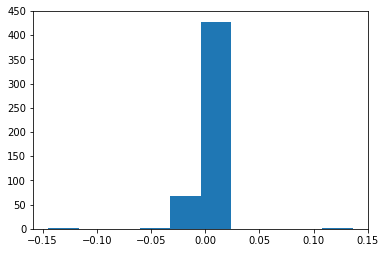

In [111]:
# Marginal effect scratch
delta = 1.5

beta = np.matrix(result.x).T
X_new = np.copy(X)
X_new[:,0] = np.reshape(X[:,0] + delta, (np.shape(X)[0]))

v_hat = X*beta
v_hat_new = X_new*beta

me_vec = CE_1(Y, v_hat, v_hat_new, 1/5) - CE_1(Y, v_hat, v_hat, 1/5)
plt.hist(me_vec)
print('Avg ME: %0.5f' % np.mean(me_vec/delta))
true_vec = f_true(X_new) - f_true(X)
print('True ME: %0.5f' % np.mean(true_vec/delta))

In [88]:
me_results = []

for delta in np.linspace(0.01, 10, num = 10):
    
    beta = np.matrix(result.x).T
    X_new = np.copy(X)
    X_new[:,0] = np.reshape(X[:,0] + delta, (np.shape(X)[0]))

    v_hat = X*beta
    v_hat_new = X_new*beta

    me_vec = CE_1(Y, v_hat, v_hat_new, 1/5) - CE_1(Y, v_hat, v_hat, 1/5)
    me_results.append([delta, np.mean(me_vec/delta)])
    
me_results   

[[0.01, 1.543078629725439],
 [1.12, 1.8384759830457036],
 [2.23, 1.926108612940292],
 [3.34, 1.9432778813556868],
 [4.45, 1.9396269141751956],
 [5.5600000000000005, 1.9573313290767087],
 [6.67, 1.9272311375604914],
 [7.78, 1.8820416818762582],
 [8.89, 1.8698772799941619],
 [10.0, 1.716800010453149]]

# Actual Data

In [123]:
import pandas as pd

In [197]:
n = 1200 # sample size
data_dmd = pd.read_csv('../data/processed/regression_data_levels_demeaned.csv').query('OrderType == "Market"').dropna()#.sample(n = n)
data_dmd.shape

(1611, 50)

In [198]:
data_dmd.head()

,MarketCenter,Quarter,Exchange,OrderCode,CoveredOrders,CoveredShares,CancelledShares,MktCtrExecShares,AwayExecShares,ExecShares_0_9,...,Rel_PrImp_AvgT,MktCtrAvg_PrImp_ExpAmt,Rel_PrImp_ExpAmt,MktCtrAvg_All_AvgT,Rel_All_AvgT,Broker,MktShare,Rebate,Rebate_Dummy,Broker_Size
0,ARCA,2015Q3,NASDAQ,11,167917,72636881,10384868,40788074,21463939,62072012,...,0.636061,0.010542,0.009003,0.474635,0.196964,Barclays Capital,0.0000,1.0,1,2.395827e+10
1,ARCA,2015Q3,NASDAQ,11,167917,72636881,10384868,40788074,21463939,62072012,...,0.636061,0.010542,0.009003,0.474635,0.196964,Cowen Execution,0.0000,0.0,0,5.018710e+07
2,ARCA,2015Q3,NASDAQ,11,167917,72636881,10384868,40788074,21463939,62072012,...,0.636061,0.010542,0.009003,0.474635,0.196964,Credit Suisse,0.0000,1.0,1,3.266721e+10
3,ARCA,2015Q3,NASDAQ,11,167917,72636881,10384868,40788074,21463939,62072012,...,0.636061,0.010542,0.009003,0.474635,0.196964,Deutsche,0.0151,1.0,1,2.045009e+10
20,ARCA,2015Q3,NYSE,11,332290,93147866,8771479,52918769,31457618,84371992,...,-0.279227,0.006620,0.004540,0.372442,-0.369889,Barclays Capital,0.0000,1.0,1,2.395827e+10


### All

In [373]:
data_dmd_mat = np.matrix(data_dmd[['MktShare', 'PrImp_ExpAmt', 'All_AvgT']])
Y = data_dmd_mat[:,0]
X = data_dmd_mat[:,1:]
guess = [1, -0.00832]

In [374]:
obj_f = lambda x_0: -SLS_1(x_0, Y, X, trim(X, 0.98))
result = minimize(obj_f, guess, method='BFGS', options = {'gtol': 1e-05})
tstats_all = find_tstats(Y, X, result)
result_all = result
result

      fun: 34.80456331769235
 hess_inv: array([[ 9.14308667e-01, -3.52484552e-04],
       [-3.52484552e-04,  1.27692012e-05]])
      jac: array([4.76837158e-07, 4.76837158e-07])
  message: 'Optimization terminated successfully.'
     nfev: 56
      nit: 6
     njev: 14
   status: 0
  success: True
        x: array([ 1.0087221e+00, -2.2682397e-04])

### Rebate accepting

In [375]:
data_dmd_rebate_mat = np.matrix(data_dmd.query('Rebate_Dummy == 1')[['MktShare', 'PrImp_ExpAmt', 'PrImp_AvgT']])
Y = data_dmd_rebate_mat[:,0]
X = data_dmd_rebate_mat[:,1:]

In [376]:
obj_f = lambda x_0: -SLS_1(x_0, Y, X, trim(X, 0.98))
result = minimize(obj_f, guess, method='BFGS')
tstats_paid = find_tstats(Y, X, result)
result_paid = result
result

      fun: 1.7291273604032842
 hess_inv: array([[ 9.65696052e-01, -1.23278828e-02],
       [-1.23278828e-02,  7.06990412e-04]])
      jac: array([-1.78813934e-07,  1.28149986e-06])
  message: 'Optimization terminated successfully.'
     nfev: 44
      nit: 5
     njev: 11
   status: 0
  success: True
        x: array([ 0.99596651, -0.01600973])

### Unpaid

In [377]:
data_dmd_rebate_mat = np.matrix(data_dmd.query('Rebate_Dummy == 0')[['MktShare', 'PrImp_ExpAmt', 'PrImp_AvgT']])
Y = data_dmd_rebate_mat[:,0]
X = data_dmd_rebate_mat[:,1:]

In [378]:
obj_f = lambda x_0: -SLS_1(x_0, Y, X, trim(X, 0.98))
result = minimize(obj_f, guess, method='BFGS')
tstats_unpaid = find_tstats(Y, X, result)
result_unpaid = result
result

      fun: 29.435237012198883
 hess_inv: array([[7.46634720e-01, 1.06780919e-02],
       [1.06780919e-02, 4.13900957e-04]])
      jac: array([0.00000000e+00, 4.76837158e-07])
  message: 'Optimization terminated successfully.'
     nfev: 44
      nit: 6
     njev: 11
   status: 0
  success: True
        x: array([1.04195505, 0.0178853 ])

## Significance

In [379]:
display('T-Stats (All)', tstats_all)
display('T-Stats (Paid)', tstats_paid)
display('T-Stats (Unpaid)', tstats_unpaid)

'T-Stats (All)'

array([        nan, -0.20954218])

'T-Stats (Paid)'

array([        nan, -4.51375588])

'T-Stats (Unpaid)'

array([       nan, 2.50617519])

## Marginal Effects

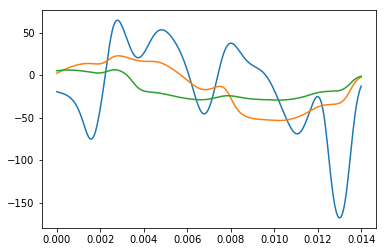

In [380]:
# All
result = result_all
point = np.matrix(np.mean(X, axis = 0))
me_results = calculate_me_range(Y, X, result, ind, point, delta = .001, n_1 = 300, n_2 = 3, delta_range = [0.001, 0.01])
plt.plot(me_results[:,0],me_results[:,1]);

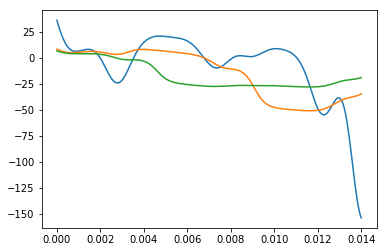

In [381]:
# Paid
result = result_paid
me_results = calculate_me_range(Y, X, result, ind, point, delta = .001, n_1 = 300, n_2 = 3, delta_range = [0.001, 0.01])
plt.plot(me_results[:,0],me_results[:,1]);

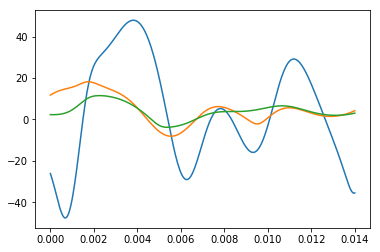

In [382]:
# Unpaid
result = result_unpaid
me_results = calculate_me_range(Y, X, result, ind, point, delta = .001, n_1 = 300, n_2 = 3, delta_range = [0.001, 0.01])
plt.plot(me_results[:,0],me_results[:,1]);

In [390]:
point = np.mean(np.matrix(data_dmd[['PrImp_ExpAmt', 'PrImp_AvgT']]), axis = 0)
display(point)

data_dmd_rebate_mat = np.matrix(data_dmd.query('Rebate_Dummy == 0')[['MktShare', 'PrImp_ExpAmt', 'PrImp_AvgT']])
Y = data_dmd_rebate_mat[:,0]
X = data_dmd_rebate_mat[:,1:]
me_results_unpaid = calculate_me_range(Y, X, result_unpaid, ind, point, delta = .001, n_1 = 300, n_2 = 2, delta_range = [0.01, 0.001])

data_dmd_rebate_mat = np.matrix(data_dmd.query('Rebate_Dummy == 1')[['MktShare', 'PrImp_ExpAmt', 'PrImp_AvgT']])
Y = data_dmd_rebate_mat[:,0]
X = data_dmd_rebate_mat[:,1:]
me_results_paid   = calculate_me_range(Y, X, result_paid,   ind, point, delta = .001, n_1 = 300, n_2 = 2, delta_range = [0.01, 0.001])

matrix([[0.00628814, 0.08655341]])

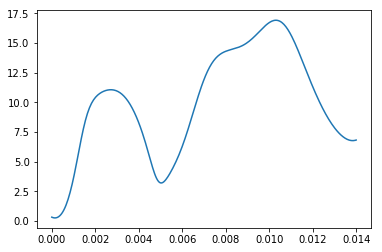

In [391]:
ind_3 = 0
plt.plot(me_results_paid[:,0,ind_3], me_results_unpaid[:,1,ind_3] - me_results_paid[:,1,ind_3])

In [273]:
# At CDRG's stats
CDRG_X = [0.01077, .161658]

display(compute_marginal_effect(Y, X, 0, np.matrix(CDRG_X), np.matrix(result_all.x).T,    delta = 0.001)*0.001)
display(compute_marginal_effect(Y, X, 0, np.matrix(CDRG_X), np.matrix(result_paid.x).T,   delta = 0.001)*0.001)
display(compute_marginal_effect(Y, X, 0, np.matrix(CDRG_X), np.matrix(result_unpaid.x).T, delta = 0.001)*0.001)

-0.06137082926080901

0.004517107899195072

0.011406665156122264

# Significance

In [ ]:
V = convert_hessian_to_cov(Y, X, result)

t_stat = (result.x[1]/result.x[0]) / V[1,1]
display('Theta_1 T_Stat: %0.5f' % t_stat)

# Scratch

In [344]:
data_dmd_rebate_mat = np.matrix(data_dmd.query('Rebate_Dummy != 0')[['MktShare', 'PrImp_ExpAmt', 'PrImp_AvgT']])
Y = data_dmd_rebate_mat[:,0]
X = data_dmd_rebate_mat[:,1:]

In [345]:
obj_f = lambda beta: np.sum(np.power(Y - X*np.matrix(beta).T, 2))
result = minimize(obj_f, [1,2], method='BFGS')
result

      fun: 5.298272978053775
 hess_inv: array([[ 3.12509408e+01, -3.11660929e-01],
       [-3.11660929e-01,  1.34274422e-02]])
      jac: array([5.96046448e-08, 5.96046448e-08])
  message: 'Optimization terminated successfully.'
     nfev: 36
      nit: 7
     njev: 9
   status: 0
  success: True
        x: array([10.55627117, -0.02126072])

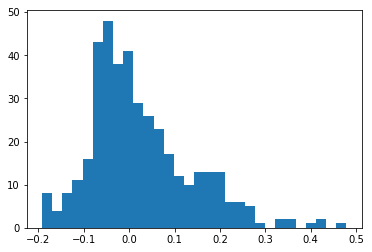

In [346]:
plt.hist(Y - X*np.matrix(result.x).T, bins = 30);